In [1]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import gc
from pathlib import Path

In [2]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py'>

In [3]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/output/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/annotation/"

In [4]:
# get folder list 
# load for each site the normalized files
# reduce the features selecting the correct feature list
folders = [name for name in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, name))]

In [5]:
def extract_plate_info(path): 
     
    match = re.search(r'(\d{4}-\d{2}-\d{2}_[A-Za-z0-9]+_R\d)', path)
    full_id = match.group(1) if match else None

    # Extract the date string (e.g., 2024-06-05)
    date_match = re.search(r'(\d{4}-\d{2}-\d{2})', full_id) if full_id else None
    batch = date_match.group(1) if date_match else None

    id_match  = re.search(r'_([A-Za-z0-9]+)_R(\d)', full_id) if full_id else None
    plate = id_match.group(1) if id_match else None
    replicate = id_match.group(2) if id_match else None

    return {
        "path": path,
        "full_id": full_id,
        "batch": batch,
        "plate": plate,
        "replicate": f"R{replicate}" if replicate else None
    }

In [6]:
site_specific_path = os.path.join(input_path, 'FMP')

# loads mad_robustize normalized data
pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize.csv"
file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

files = [extract_plate_info(path) for path in file_list]

file_dataframe = pd.DataFrame(files)

file_dataframe['plate_replicate'] = file_dataframe['plate'] + '_' + file_dataframe['replicate']

In [7]:
file_dataframe['batch'].unique

<bound method Series.unique of 0      2025-07-18
1      2024-09-06
2      2024-10-02
3      2024-09-06
4      2024-07-10
          ...    
367    2024-10-02
368    2024-10-02
369    2025-08-15
370    2025-08-27
371    2025-07-23
Name: batch, Length: 372, dtype: object>

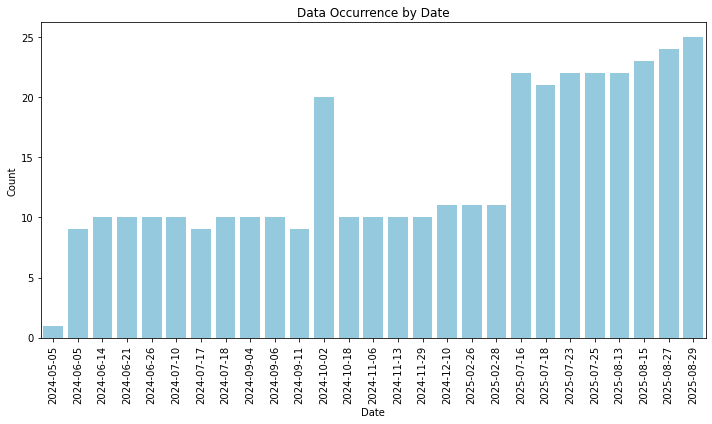

In [8]:
# Count occurrences per date
date_counts = file_dataframe['batch'].value_counts().reset_index()
date_counts.columns = ['date', 'count']
date_counts = date_counts.sort_values('date')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=date_counts, x='date', y='count', color='skyblue')
plt.title('Data Occurrence by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
# compute new feature set for each site using correlation based feature redcution
def reduced_features(dataset_to_reduce, name_pre_fix, site_name ):

    reduced_feature_dataframe = CBE.feature_reduction(dataset_to_reduce,
                                             variance_freq_cut=0.1,
                                             variance_unique_cut=0.1,
                                             outlier_cutoff=100,
                                             corr_threshold = 0.9,
                                             print_stats = True)

    filename_norm_reduced_features = site_name + "_" + name_pre_fix + "_reduced_features.csv"

    file_path_norm_reduced_features = os.path.join(site_specific_path, filename_norm_reduced_features)
    
    reduced_feature_dataframe.to_csv(file_path_norm_reduced_features, index=False)
    
    return CBE.get_feature_vector(reduced_feature_dataframe)

In [10]:
Data = []

site_specific_path = os.path.join(input_path, "FMP")


# loads mad_robustize normalized data
pattern = "[A-Z]*_R[1-4]_mad_robustize.csv"
file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

files = [extract_plate_info(path) for path in file_list]

file_dataframe = pd.DataFrame(files)

file_dataframe['plate_replicate'] = file_dataframe['plate'] + '_' + file_dataframe['replicate']


In [11]:
def concatenate_data(file_list):

    for file in file_list:
        
        plate_map_name = os.path.splitext(os.path.basename(file))[0]
        
        try:
            dataframe = pd.read_csv(file)
            row_count = dataframe.shape[0]

            Data.append(dataframe)
        
            print(f"INFO: {plate_map_name} has {row_count} rows")
        
        except Exception as e:
        
            print(f"Error reading file {file}: {e}")

    Data_aggregated = pd.concat(Data)
    Data_aggregated = Data_aggregated.reset_index(drop = True)

    return Data_aggregated


In [12]:
remove_batch = ['2024-06-05', 
                '2024-06-14', 
                '2024-06-19',
                '2024-06-21',
                '2024-06-26',
                '2024-07-10',
                '2024-07-17',
                '2024-07-18']

remove_batch_df = pd.to_datetime(remove_batch)
file_dataframe['date'] = pd.to_datetime(file_dataframe['batch'])
file_dataframe_corrected = file_dataframe[~file_dataframe['date'].isin(remove_batch_df)]

In [13]:
file_firstrun_list = file_dataframe_corrected['path'].tolist()
file_firstrun_aggregate = concatenate_data(file_firstrun_list)
FMP_firstrun_feature_set = reduced_features(file_firstrun_aggregate , 'firstrun', 'FMP')
len(FMP_firstrun_feature_set)

INFO: C1151_R2_mad_robustize has 384 rows
INFO: C1104_R2_mad_robustize has 384 rows
INFO: C1119_R1_mad_robustize has 384 rows
INFO: C1112_R2_mad_robustize has 383 rows
INFO: C1123_R2_mad_robustize has 384 rows
INFO: C1095_R3_mad_robustize has 384 rows
INFO: FMP02_R1_mad_robustize has 383 rows
INFO: C1098_R4_mad_robustize has 384 rows
INFO: C1143_R1_mad_robustize has 384 rows
INFO: C1090_R1_mad_robustize has 384 rows
INFO: C1143_R1_mad_robustize has 195 rows
INFO: C1119_R4_mad_robustize has 384 rows
INFO: C1099_R2_mad_robustize has 360 rows
INFO: C1103_R1_mad_robustize has 384 rows
INFO: C1089_R1_mad_robustize has 384 rows
INFO: C1111_R1_mad_robustize has 384 rows
INFO: C1123_R2_mad_robustize has 354 rows
INFO: C1113_R1_mad_robustize has 384 rows
INFO: FMP11_R1_mad_robustize has 384 rows
INFO: C1132_R2_mad_robustize has 384 rows
INFO: C1116_R1_mad_robustize has 384 rows
INFO: C1130_R4_mad_robustize has 384 rows
INFO: C1100_R1_mad_robustize has 384 rows
INFO: C1128_R4_mad_robustize has 3

346

In [14]:
def apply_reduction(reduced_feature_set, site_name):
    
    dataframes_normalized_reduced_dict = {}

    site_specific_path = os.path.join(input_path, site_name)

    pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize.csv"
    file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

    for file in file_list:
    
        plate_map_name = os.path.splitext(os.path.basename(file))[0]
    
        try:
        
            dataframe = pd.read_csv(file)
            row_count = dataframe.shape[0]
        
            print(f"INFO: {plate_map_name} has {row_count} rows")

            features = CBE.get_feature_vector(dataframe)
            metadata = set(dataframe.columns) - set(features)

            number_features = len(features)

            print(f"INFO: {plate_map_name} has {number_features} features")

            features_to_remove = [item for item in features if item not in reduced_feature_set]
    
            dataframe_reduced_features = dataframe.drop(columns = features_to_remove)

            reduced_features = CBE.get_feature_vector(dataframe_reduced_features)

            number_reduced_features = len(reduced_features)

            print(f"INFO: {plate_map_name} has {number_reduced_features} features after feature reduction")
    
            filename_norm_reduced_data = plate_map_name + "_reduced-corr.csv"
    
            path_norm_reduced_data = os.path.dirname(file)
            file_path_norm_reduced_data = os.path.join(path_norm_reduced_data, filename_norm_reduced_data)
    
            dataframe_reduced_features.to_csv(file_path_norm_reduced_data, index=False)
    
            print(f"INFO: Saved {filename_norm_reduced_data}")

            # dict_key = dataframe_reduced_features['Metadata_staining_date'][0].astype(str) + "_" + dataframe_reduced_features['Metadata_source'][0] + "_" + dataframe_reduced_features['Metadata_plate_map_name'][0]

            # dataframes_normalized_reduced_dict[dict_key] = dataframe_reduced_features
        
        except Exception as e:
        
            print(f"Error reading file {plate_map_name}: {e}") 

In [15]:
apply_reduction(FMP_firstrun_feature_set, 'FMP')

INFO: C1151_R2_mad_robustize has 384 rows
INFO: C1151_R2_mad_robustize has 2977 features
INFO: C1151_R2_mad_robustize has 346 features after feature reduction
INFO: Saved C1151_R2_mad_robustize_reduced-corr.csv
INFO: C1104_R2_mad_robustize has 384 rows
INFO: C1104_R2_mad_robustize has 2977 features
INFO: C1104_R2_mad_robustize has 346 features after feature reduction
INFO: Saved C1104_R2_mad_robustize_reduced-corr.csv
INFO: C1119_R1_mad_robustize has 384 rows
INFO: C1119_R1_mad_robustize has 2977 features
INFO: C1119_R1_mad_robustize has 346 features after feature reduction
INFO: Saved C1119_R1_mad_robustize_reduced-corr.csv
INFO: C1112_R2_mad_robustize has 383 rows
INFO: C1112_R2_mad_robustize has 2977 features
INFO: C1112_R2_mad_robustize has 346 features after feature reduction
INFO: Saved C1112_R2_mad_robustize_reduced-corr.csv
INFO: C1100_R2_mad_robustize has 384 rows
INFO: C1100_R2_mad_robustize has 2977 features
INFO: C1100_R2_mad_robustize has 346 features after feature reducti